In [19]:
import numpy as np
import matplotlib.pyplot as plt

from tunnel_book.preprocessing import load_image, downscale, depth_map, normalize_image

from tunnel_book.segmentation import get_msk_gen
from tunnel_book.viz import show_anns, show_all_segmts_ind, save_layers
from tunnel_book.cut import assign2layers_kmeans
from tunnel_book.process_seg_img import obtain_all_objects, check_overlapping

In [2]:
img = load_image("dataset/torii.jpg")

depth = depth_map(img)
img = downscale(img, *depth.shape)

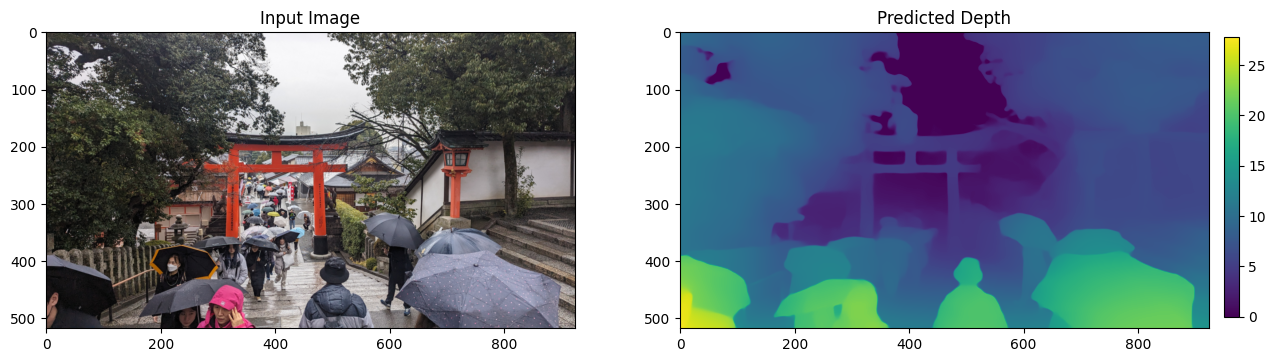

In [3]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input Image')
plt.imshow(img)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

In [4]:
object_masks = obtain_all_objects(get_msk_gen(), img)
check_overlapping(object_masks)

Iteration n=1: white pixel raito after segmentation = 0.7596525096525096, difference =1.498881807155076
Iteration n=2: white pixel raito after segmentation = 0.8454992562135419, difference =0.2888421015230915
Iteration n=3: white pixel raito after segmentation = 0.8674346888632603, difference =0.14010156514545966
Iteration n=4: white pixel raito after segmentation = 0.854723461866319, difference =0.1169098354466742
There is no overlap


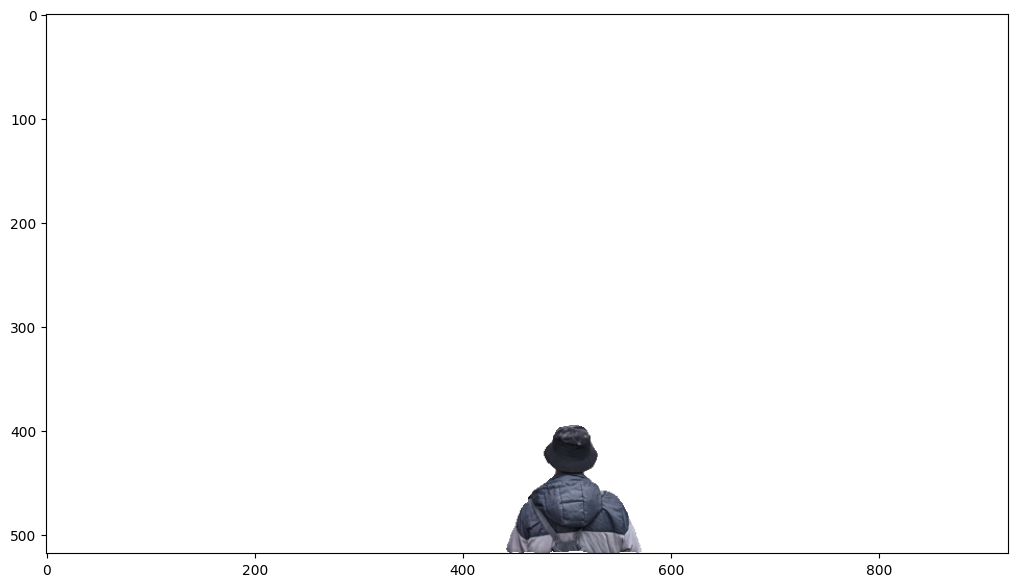

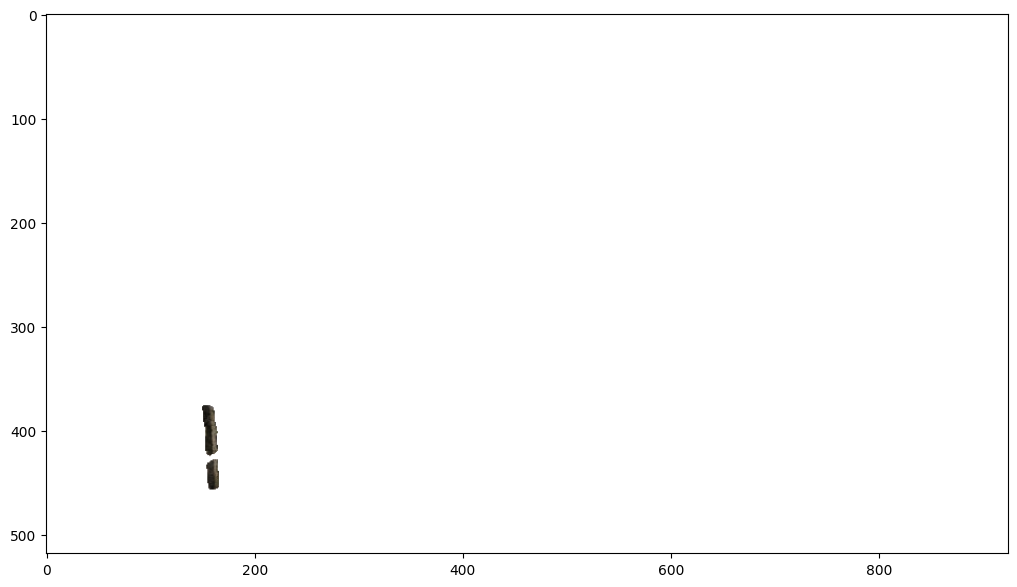

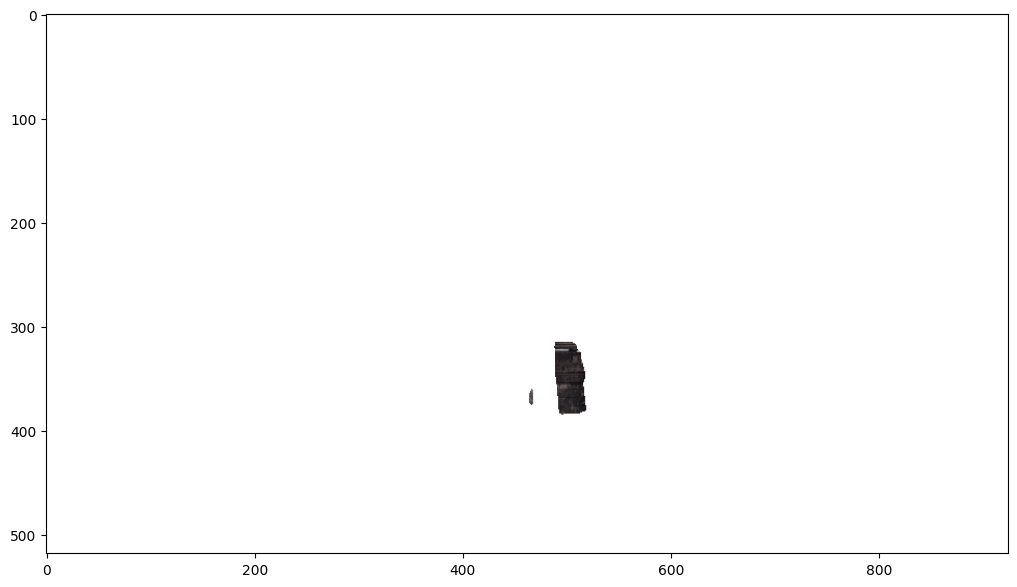

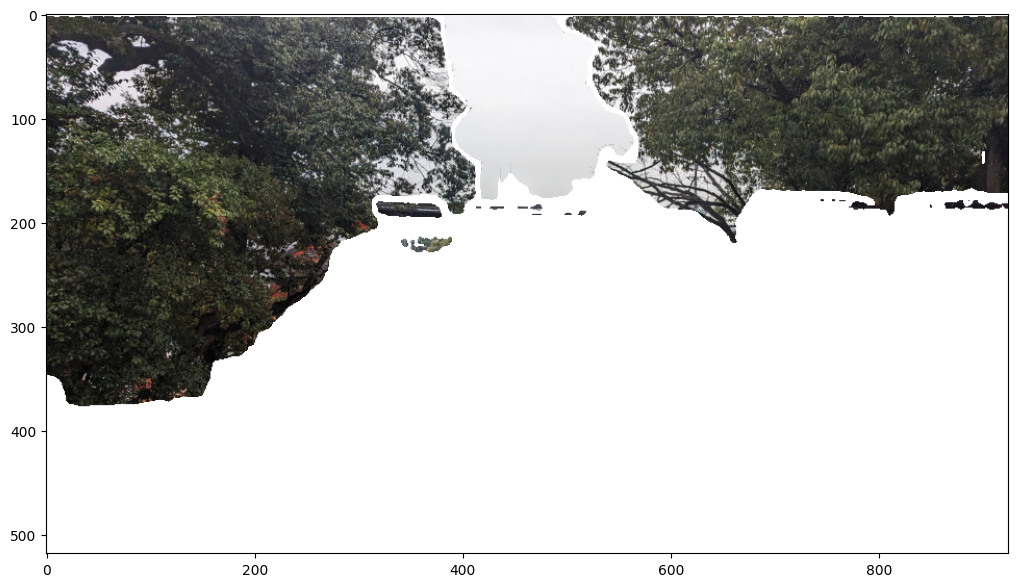

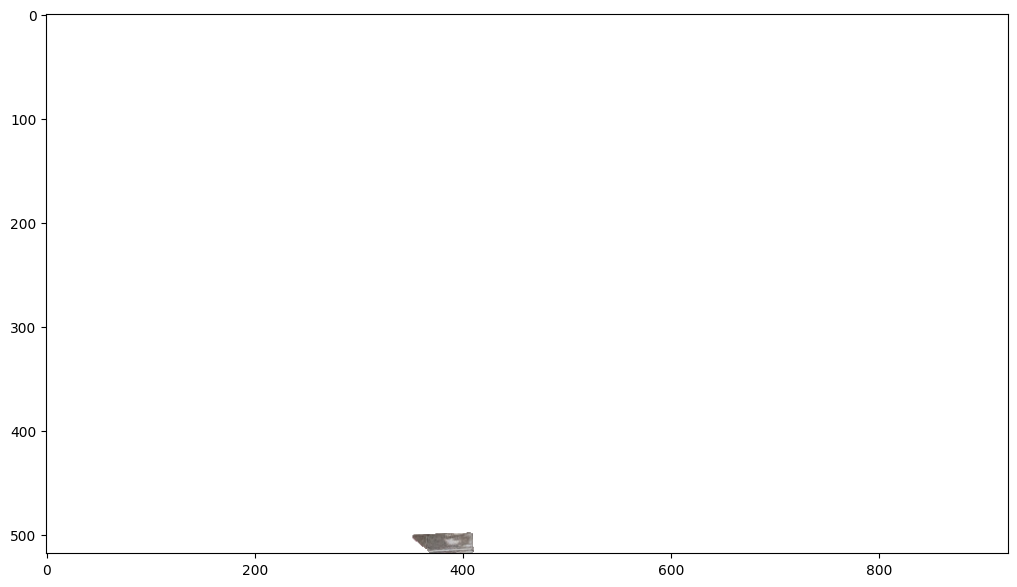

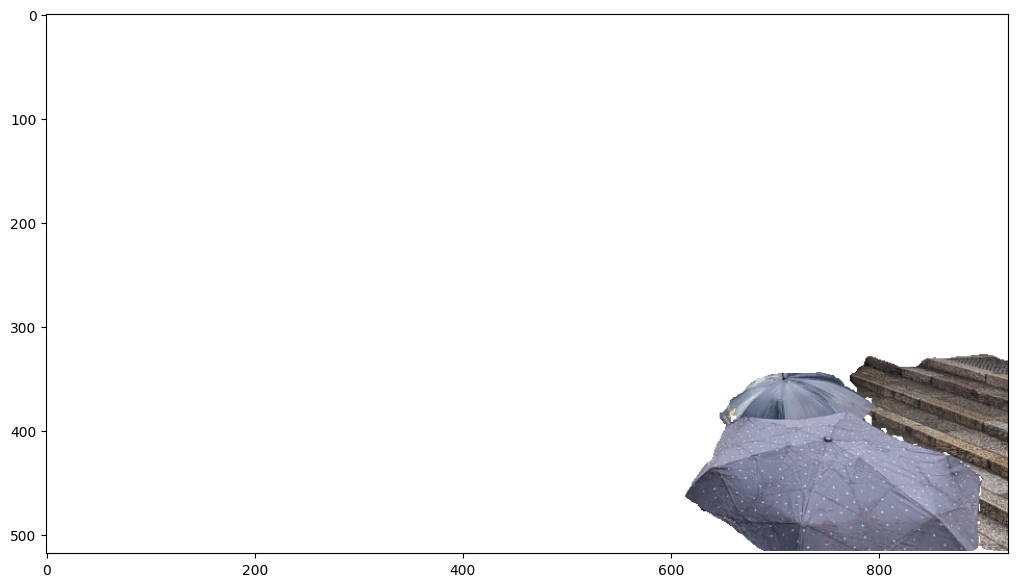

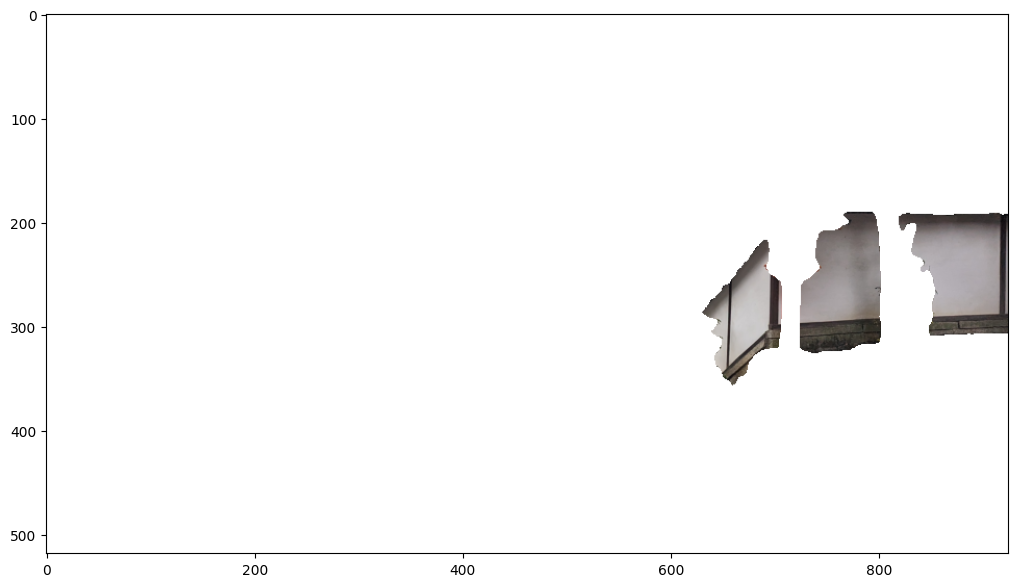

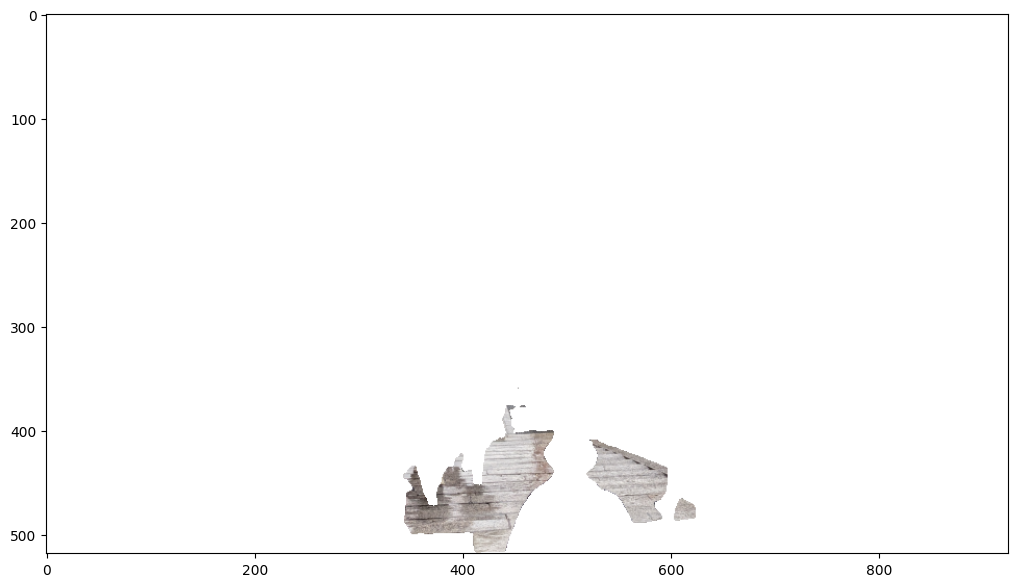

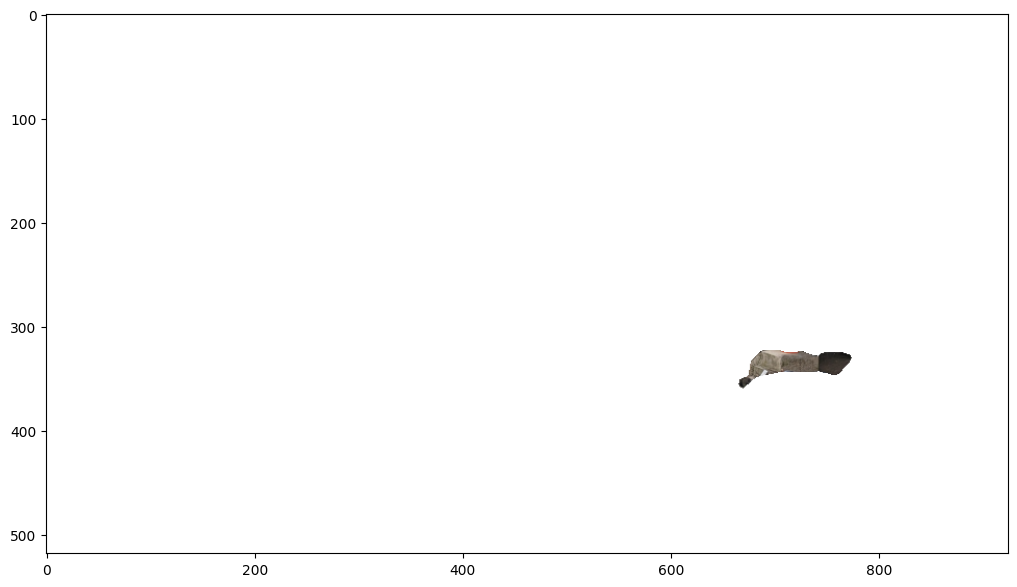

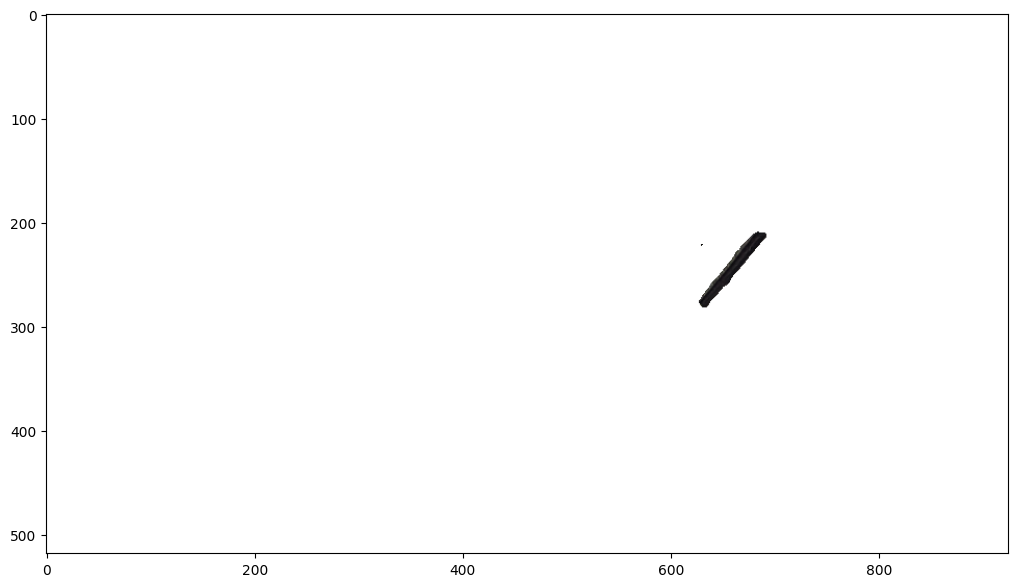

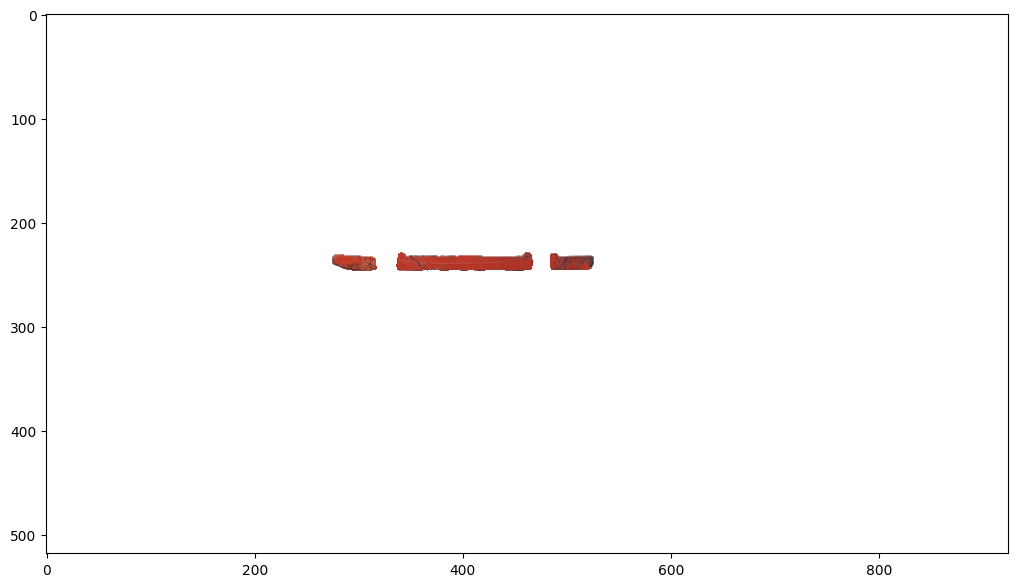

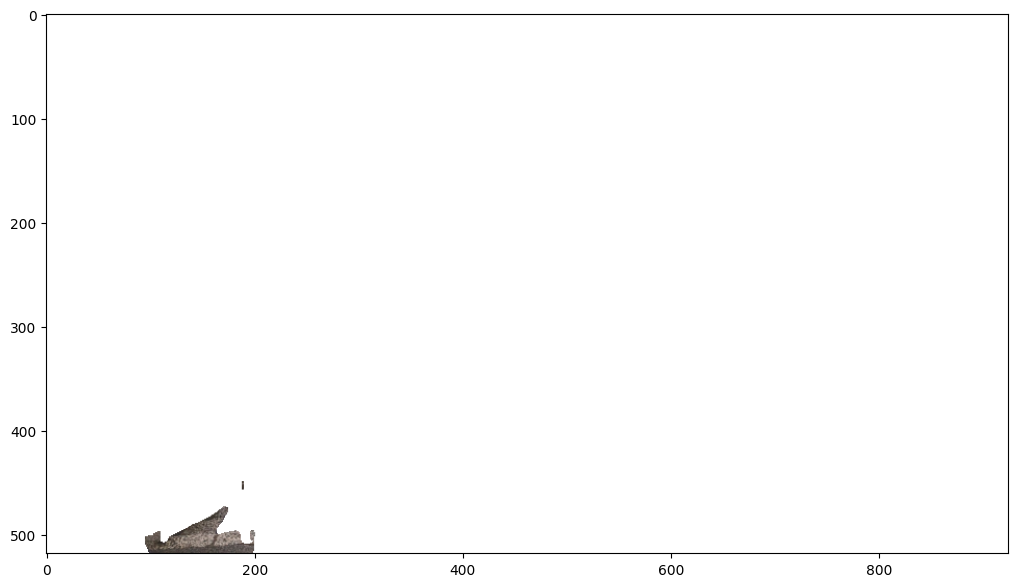

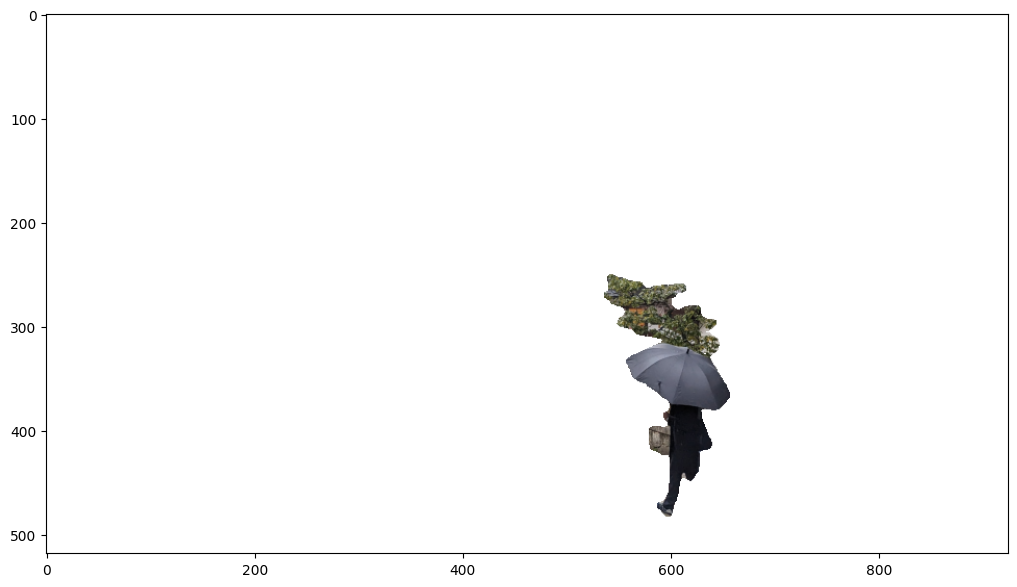

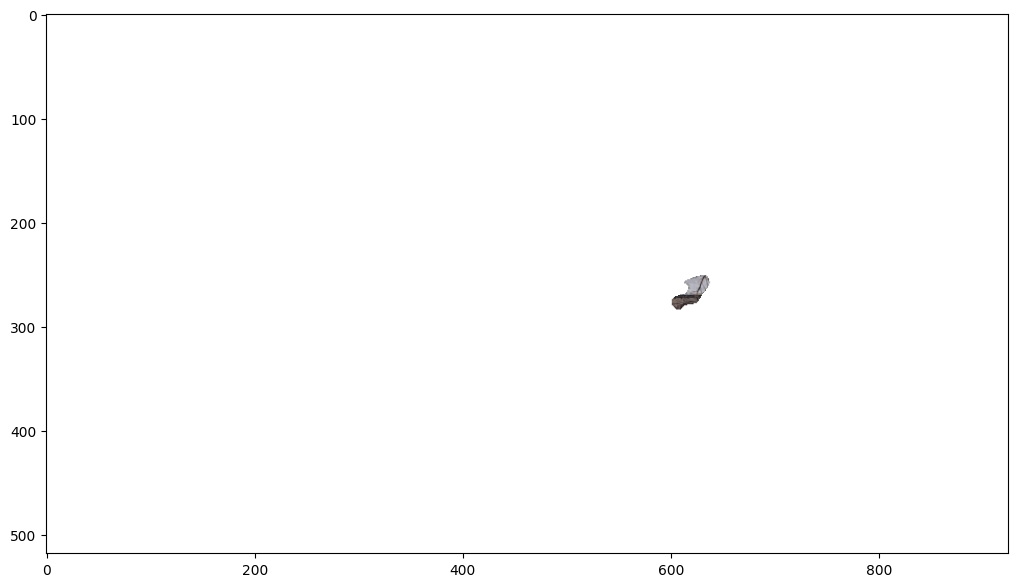

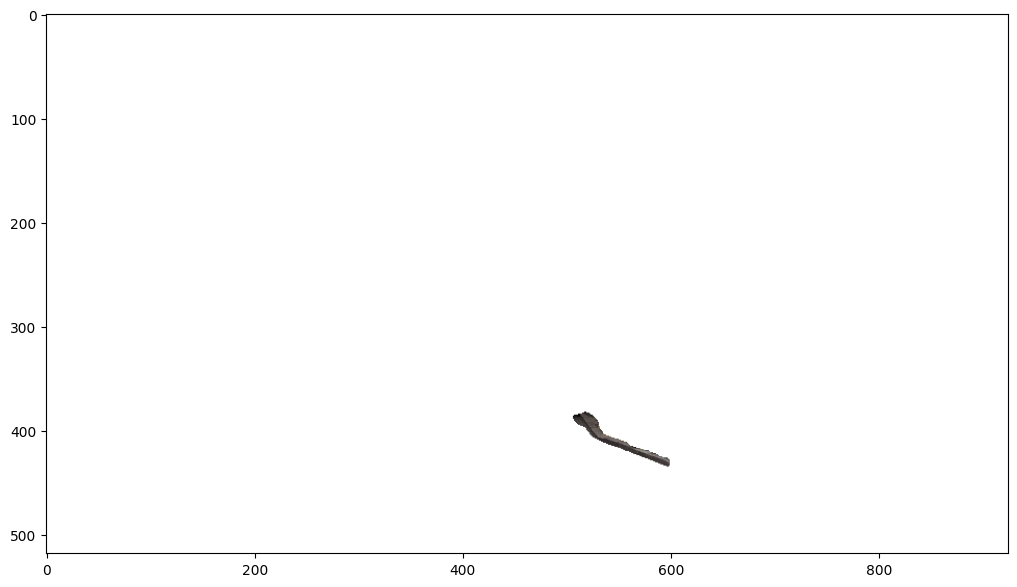

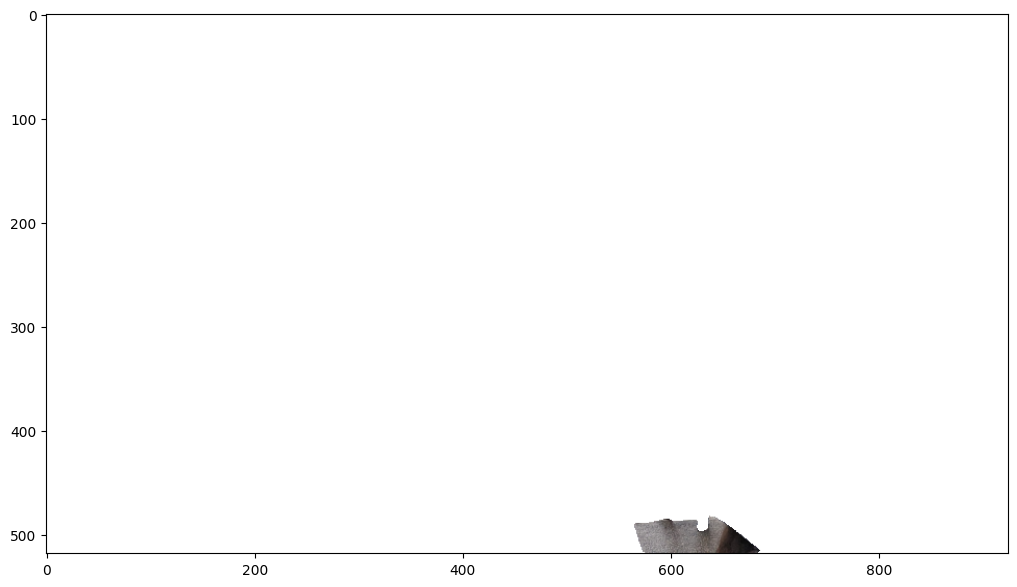

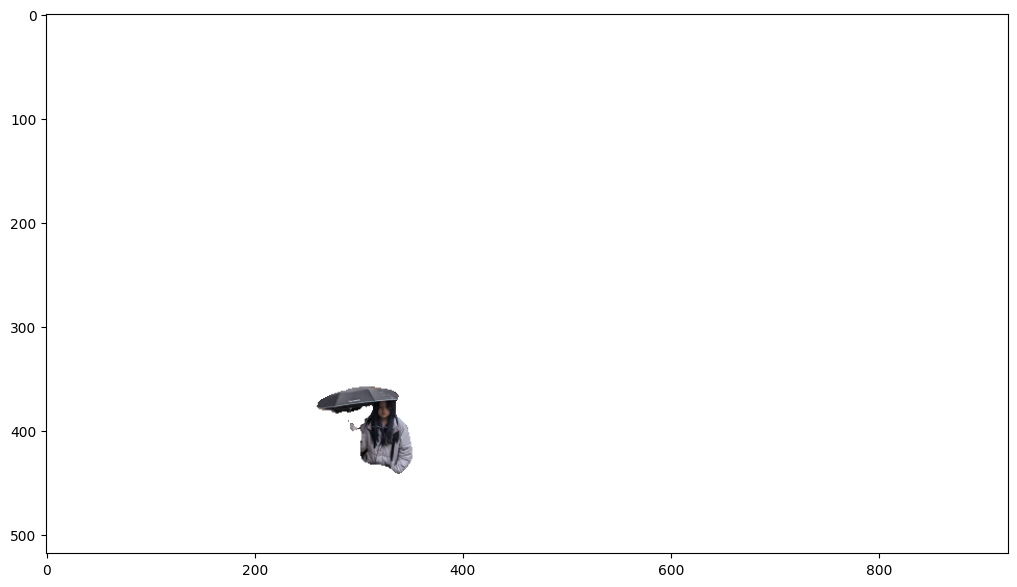

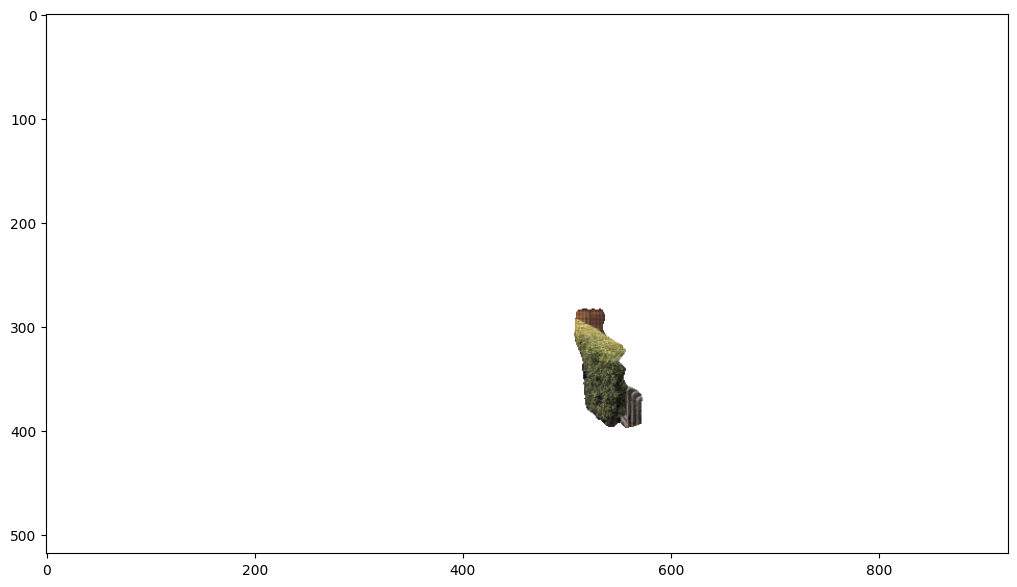

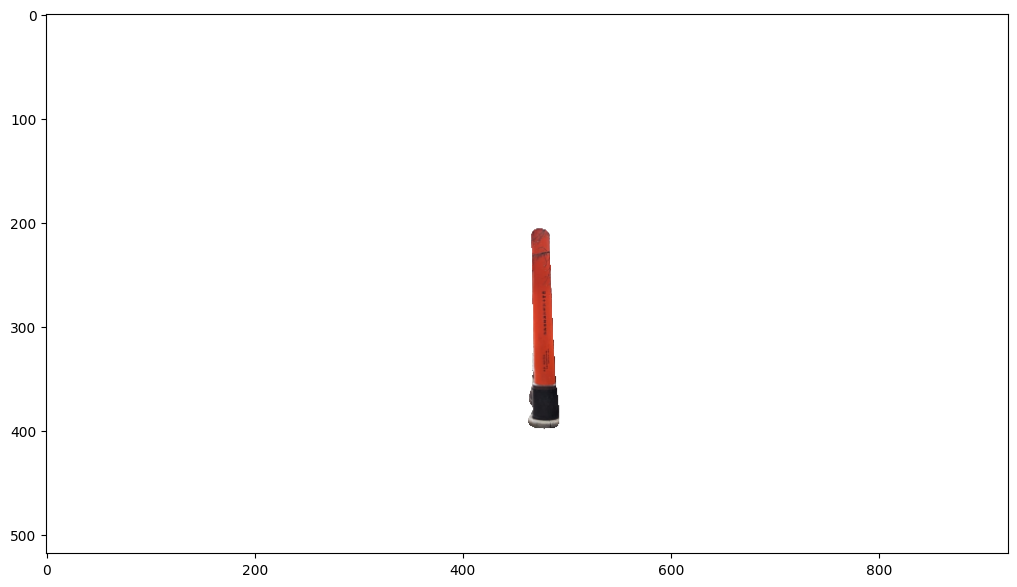

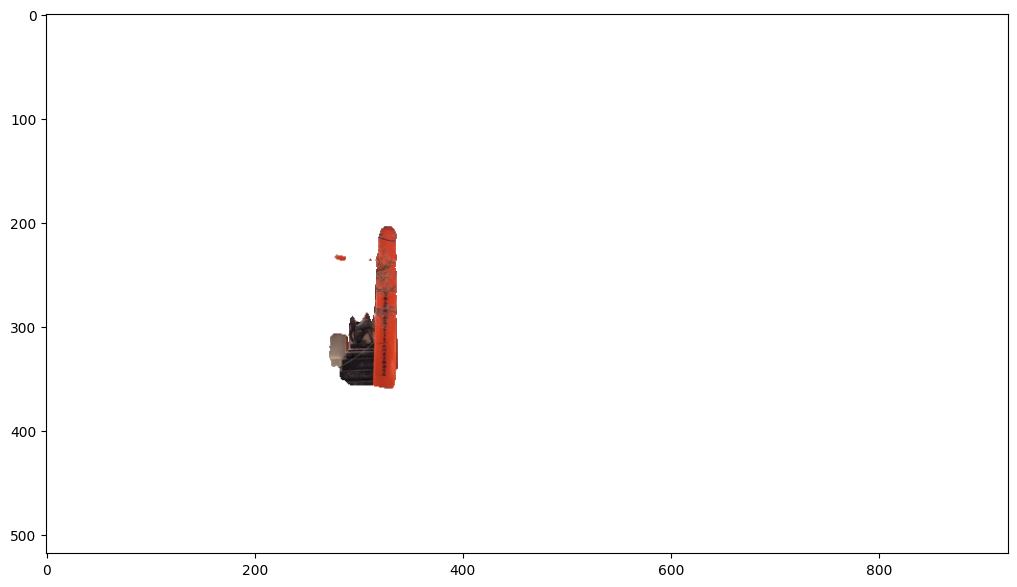

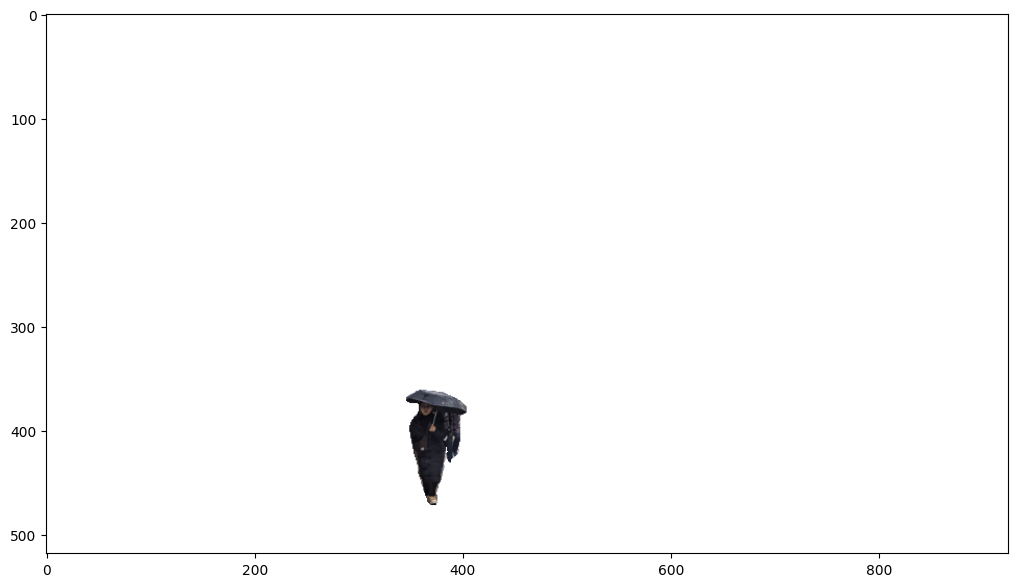

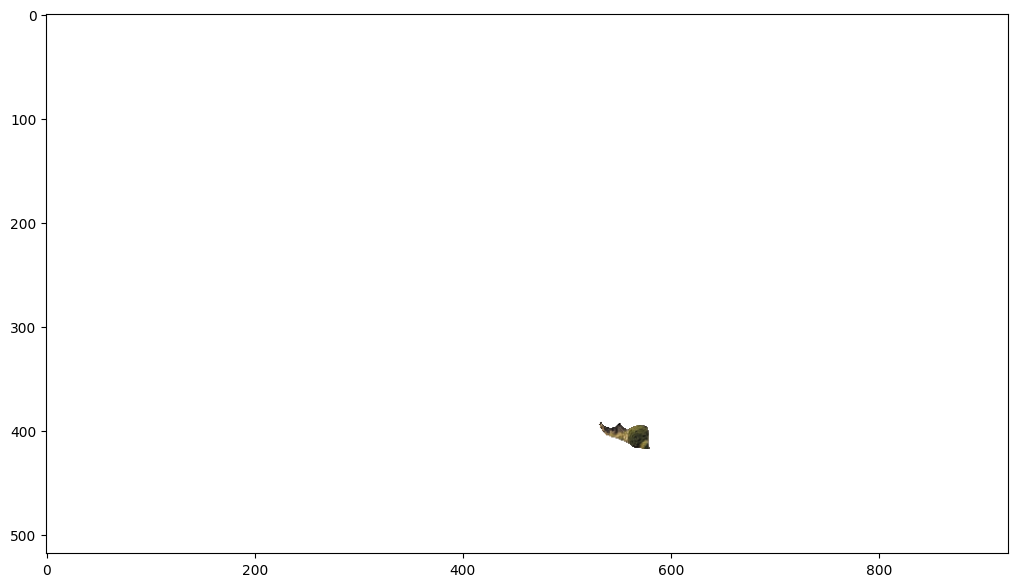

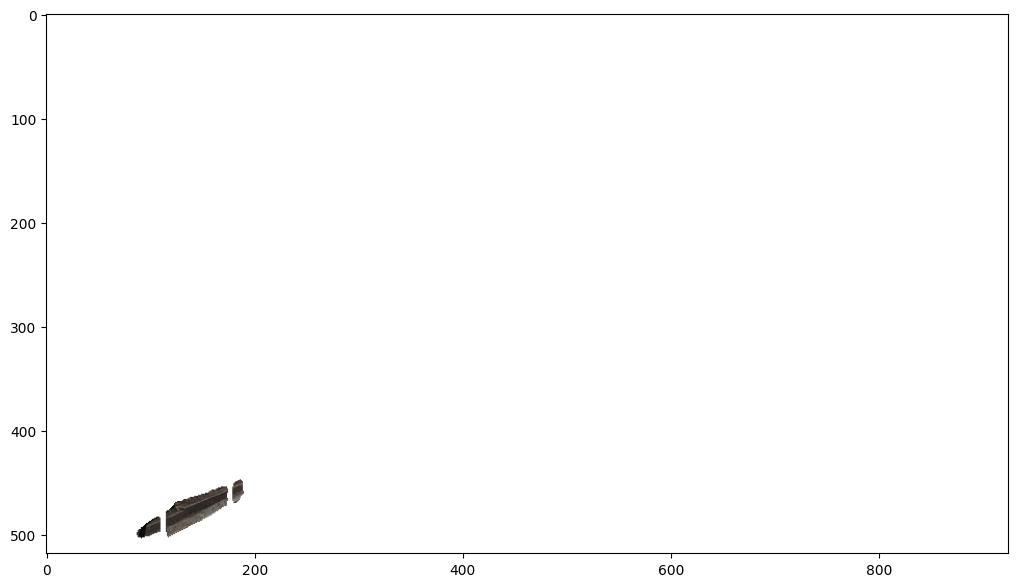

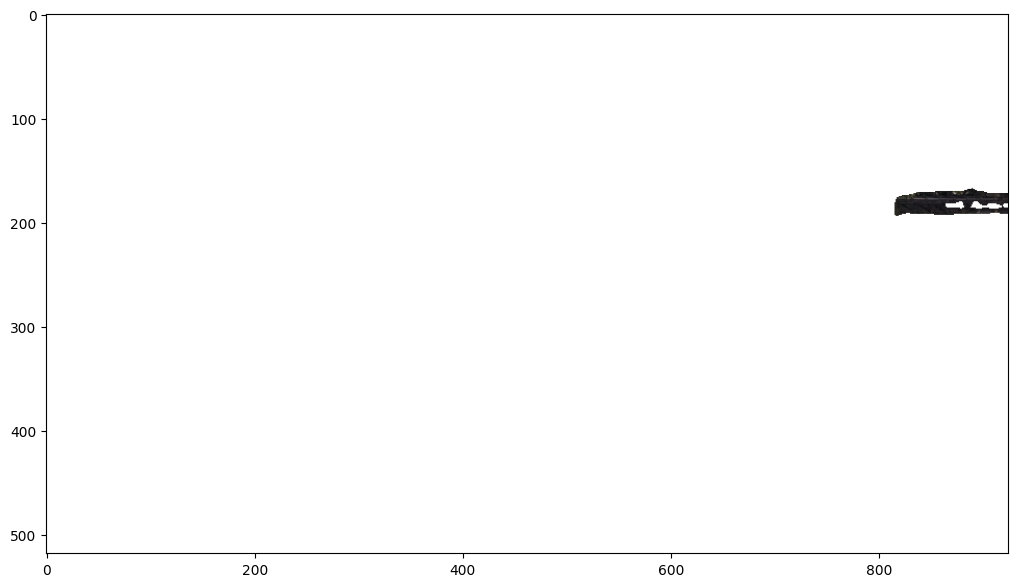

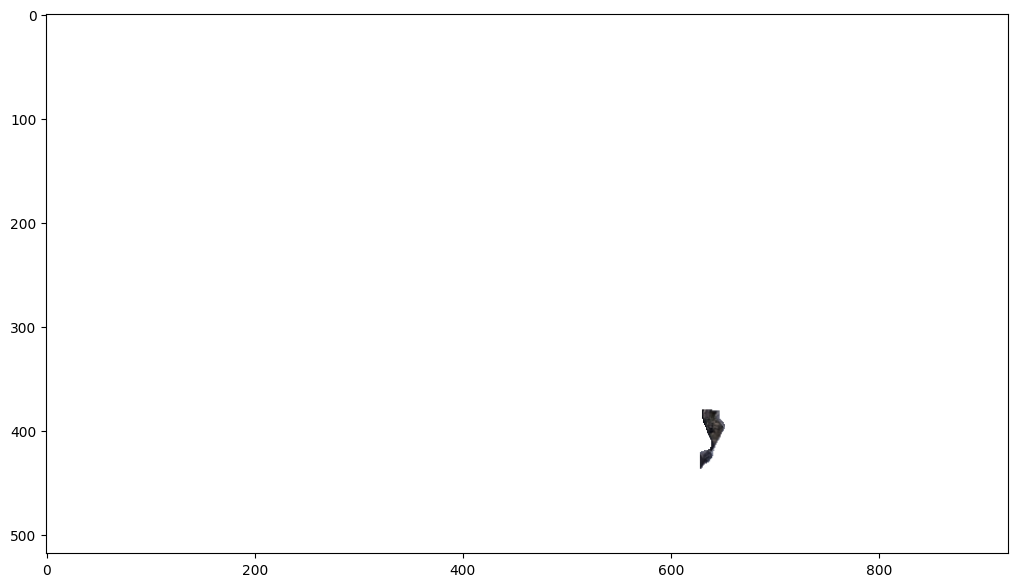

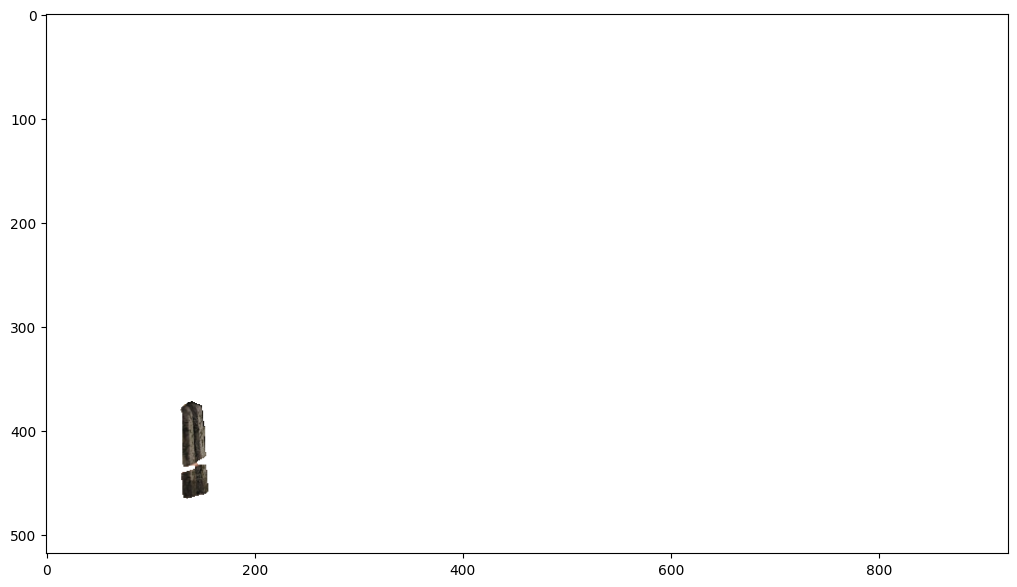

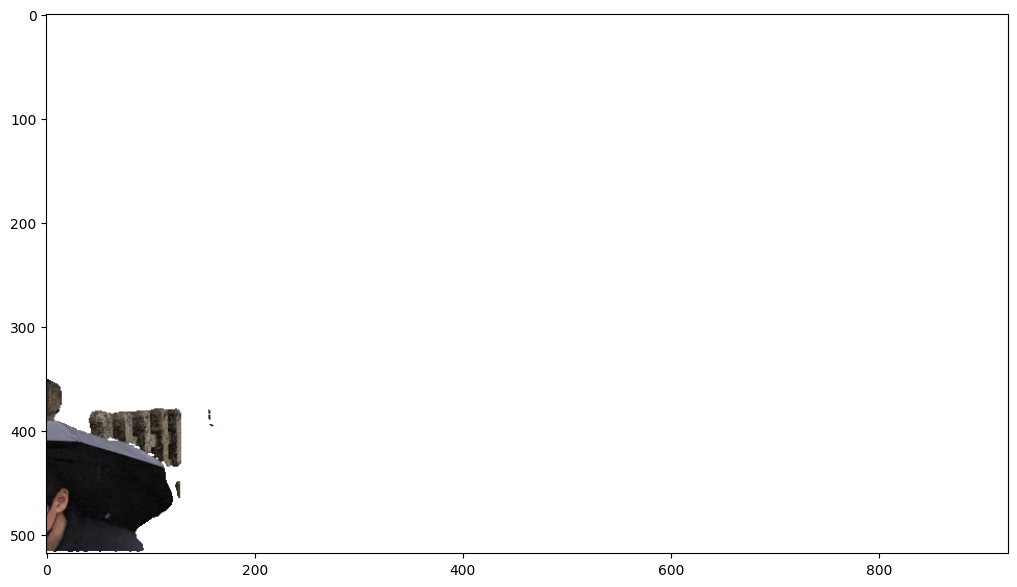

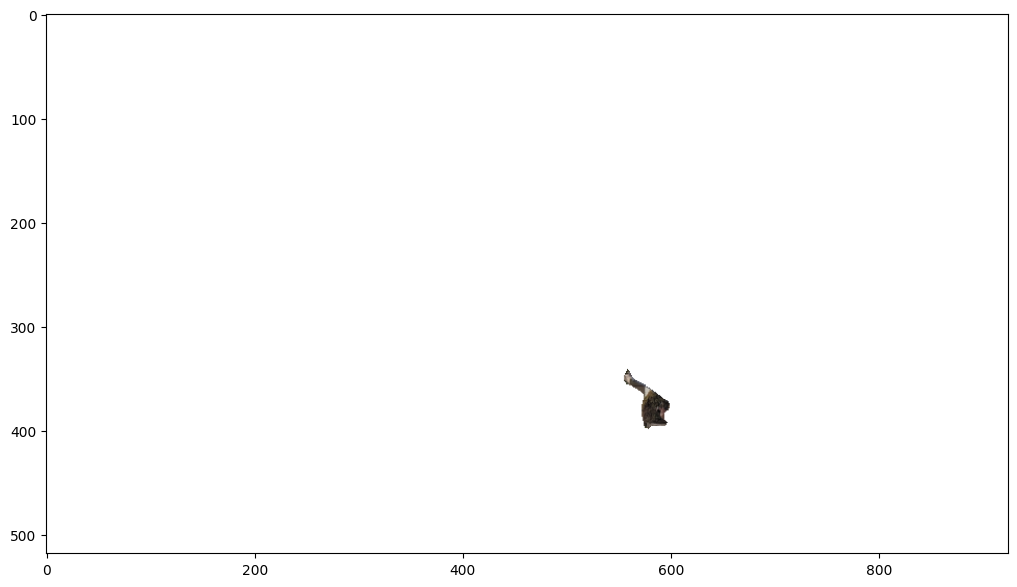

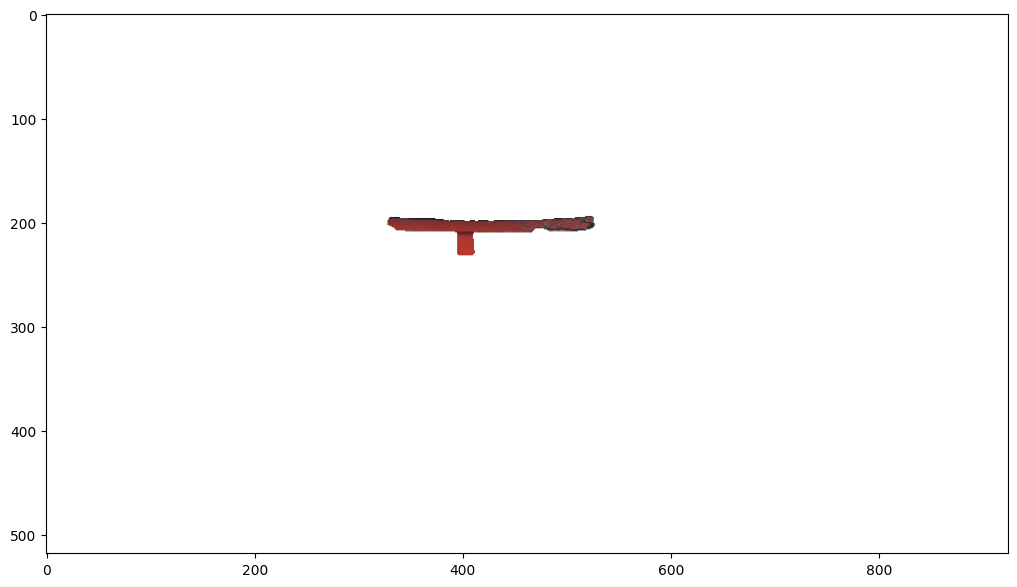

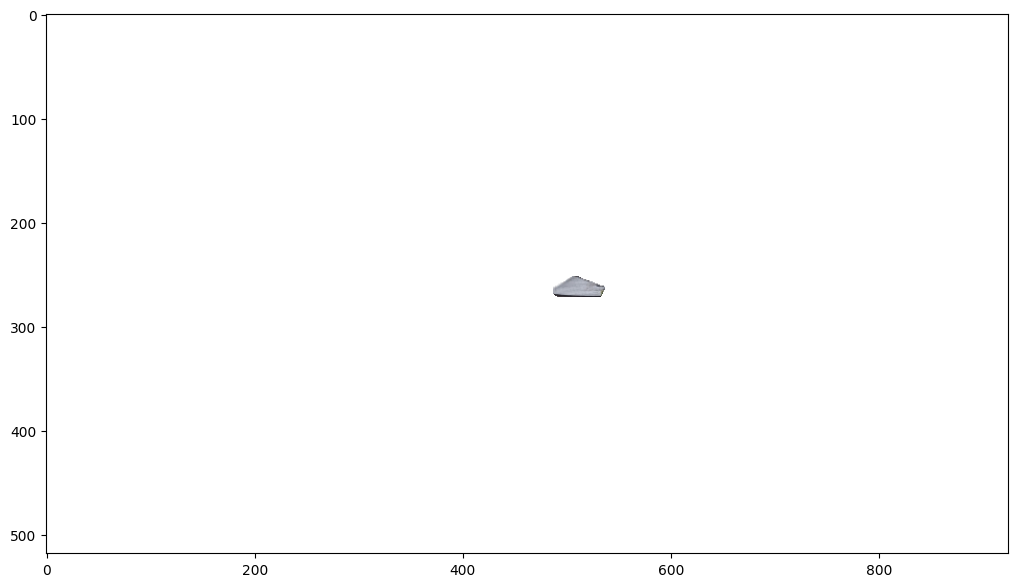

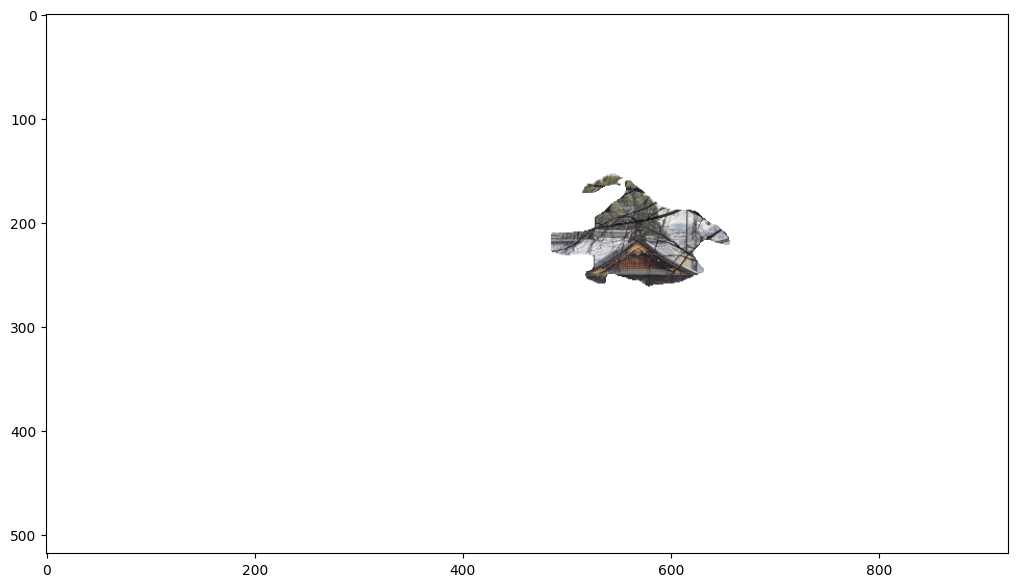

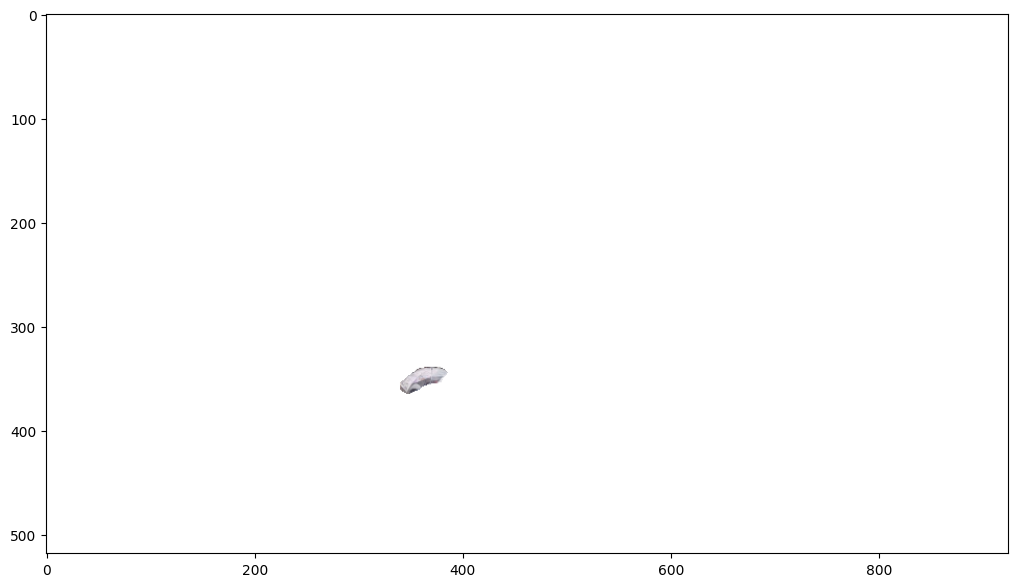

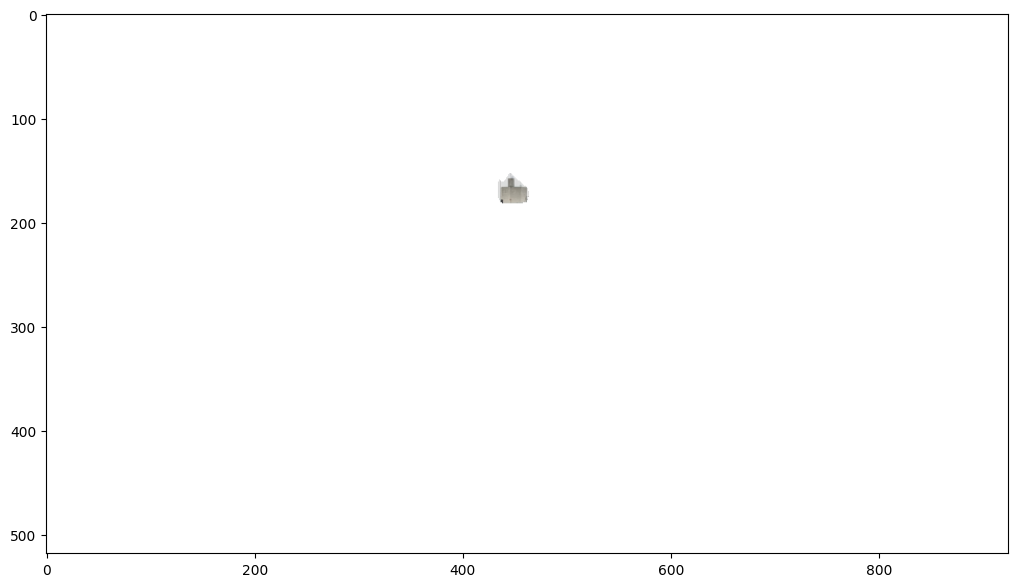

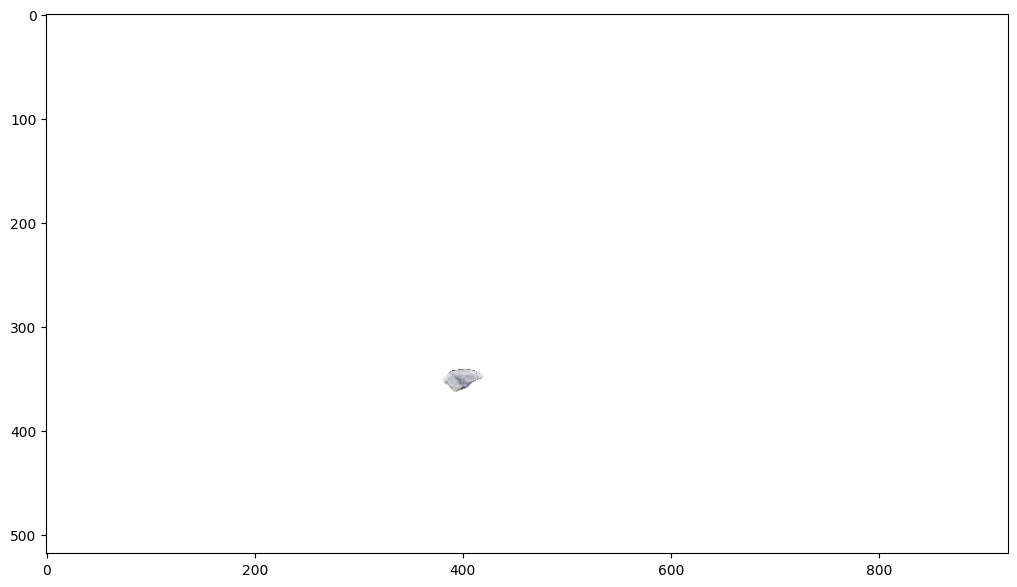

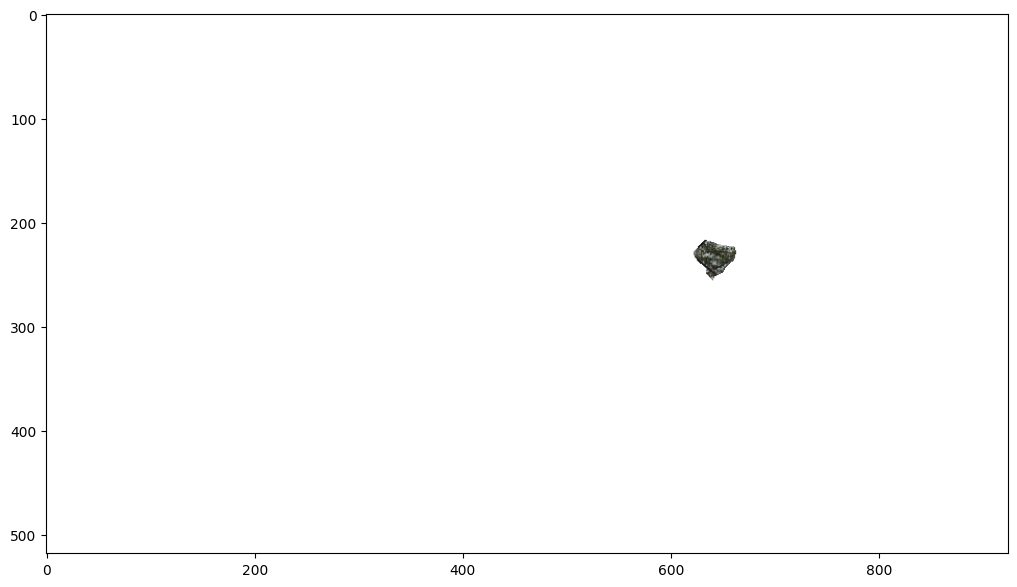

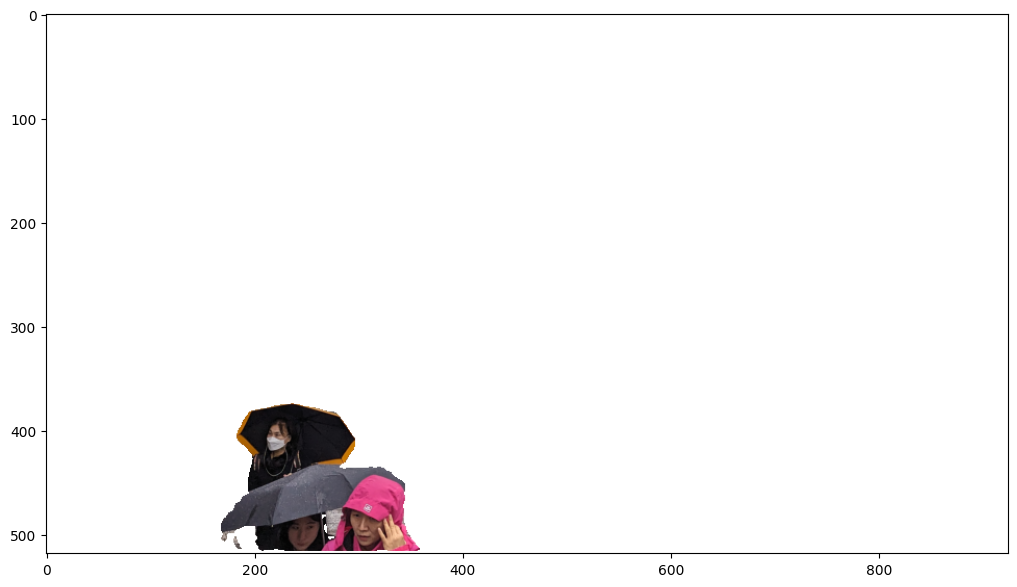

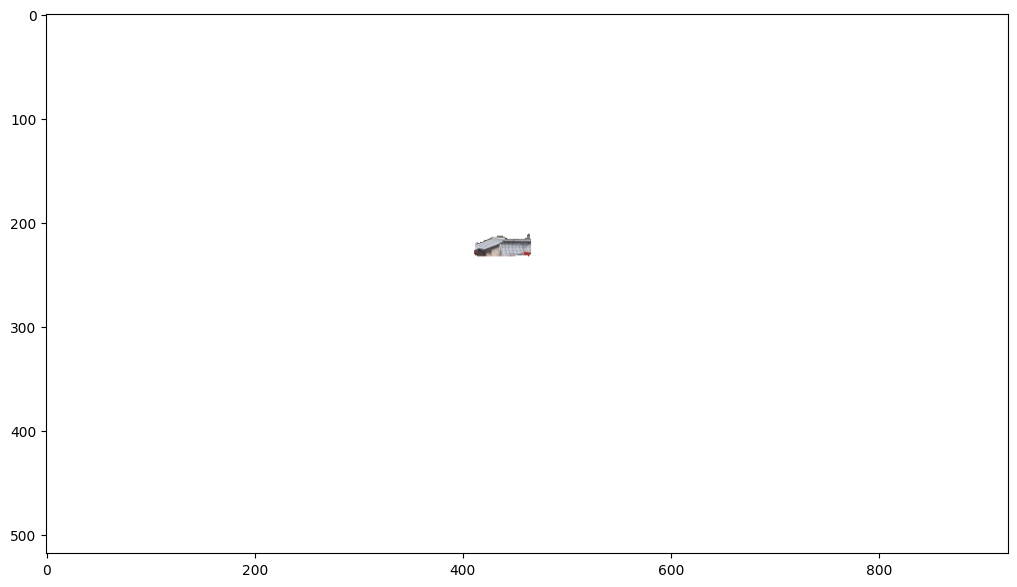

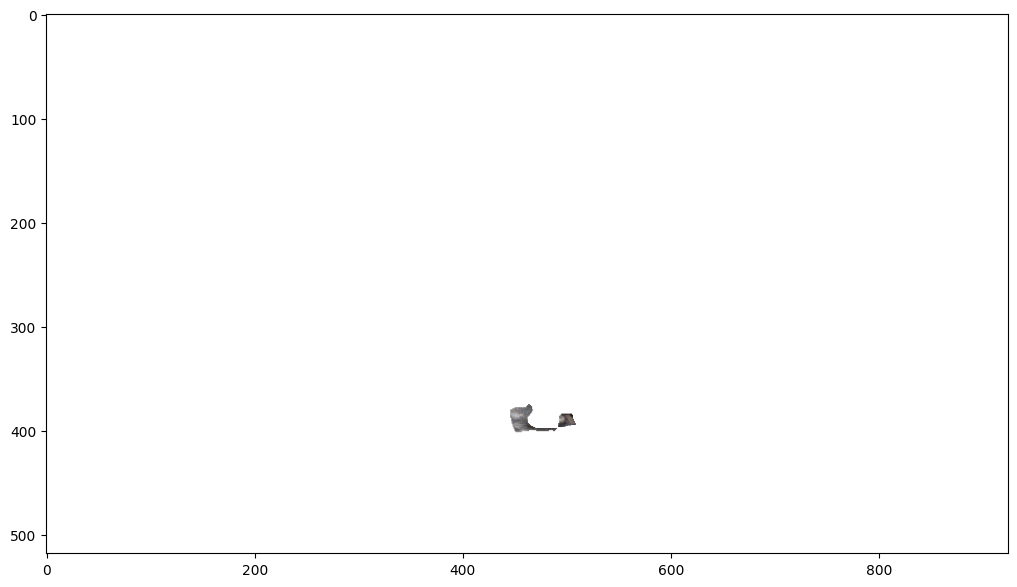

In [33]:
show_all_segmts_ind(object_masks, img)

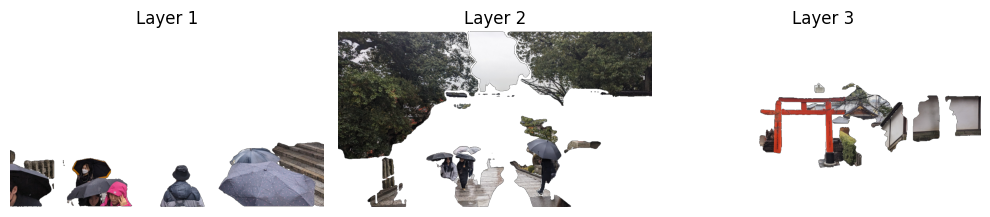

In [34]:
layers_idx, layers = assign2layers_kmeans(object_masks, depth, 3)
save_layers(img, object_masks, layers_idx, ['/tmp/layer1.png','/tmp/layer2.png','/tmp/layer3.png'])

In [7]:
from tunnel_book.preprocessing import normalize_image, slic_segmentation, kmeans

from skimage.segmentation import slic
from scipy.spatial import Delaunay
import maxflow

(216, 2)


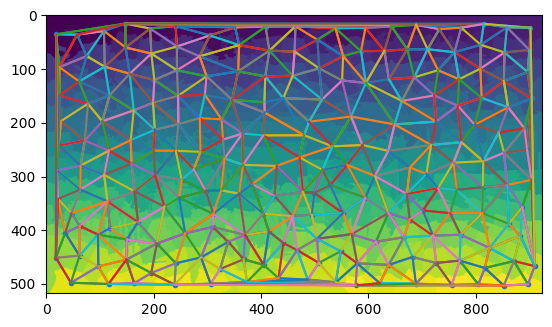

In [8]:
rgb_slic = slic(img, n_segments=250, compactness=18.5, sigma=1, start_label=1)
segments_ids = np.unique(rgb_slic)

# centers
centers = np.array([np.mean(np.nonzero(rgb_slic==i), axis=1) for i in segments_ids])
print(np.shape(centers))

# neighbors via Delaunay tesselation
tri = Delaunay(centers)

indptr, indices = tri.vertex_neighbor_vertices

plt.imshow(rgb_slic)
plt.plot(centers[:,1], centers[:,0], '.')

i = 0
for k in range(len(indptr) - 1):
    neigh = indices[indptr[k]:indptr[k+1]]
    y1, x1 = centers[k]
    
    for n in neigh:
        y2, x2 = centers[n]
        plt.plot((x1, x2), (y1, y2))

In [9]:
# basic: consider the nodes on the same layer as the free and use dikstra to get the shortest path to the edge
# generate a distorition matrix for maxflow
# - at each layer you put the cost of putting the pixel at such a layer
# - add another cost to switching layers
# - somehow force at least some path to edge?
#   - maybe perform multiple cuts with only two layers (from back to front) until there is little left
#   - then we can force the cut to somehow include the edges

# binary cut but start from most salient object at the depth and grow until we get to the edge
# - kmeans segmentation to estimate the layer depths
# - choose the most salient objects from each layer
# - each layer grows their object until a certan point (make sure they hit the edge)

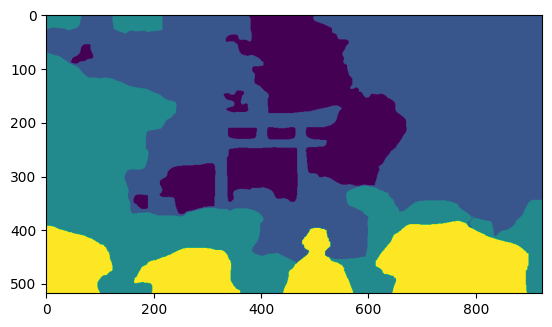

In [10]:
depth = normalize_image(depth) * 100
depth_avgs = slic_segmentation(depth, 500, 0.03, 1, 1)
depth_kmeans = kmeans(depth_avgs, 4)

plt.imshow(depth_kmeans)

[ 4 22 36 71]


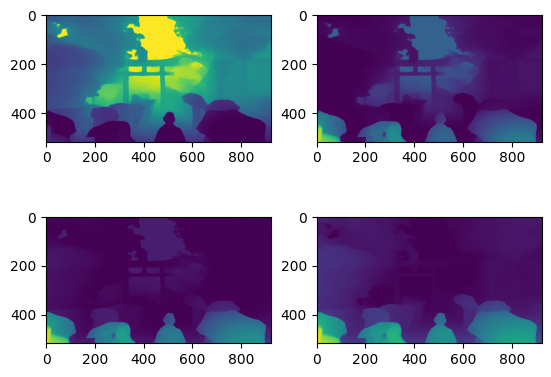

In [11]:
means = np.unique(depth_kmeans)
print(means)  # why are these integers?

n, m = depth.shape
loss = np.zeros((n, m, 4))
for i in range(4):
    loss[:,:,i] = (depth - means[i]) ** 2  # L2 loss

loss = loss[:,:,::-1]


plt.subplot(221)
plt.imshow(loss[:,:,0])

plt.subplot(222)
plt.imshow(loss[:,:,1])

plt.subplot(223)
plt.imshow(loss[:,:,2])

plt.subplot(224)
plt.imshow(loss[:,:,3])


In [12]:
# up t-links should be set to np.inf
up = np.array(
    [[[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [1, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]]])

# down t-links should hold photo consistency loss term
down = np.array(
    [[[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 0, 1],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]]])

# heigh-wise spatial consistency term
height_wise = np.array(
    [[[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]]])

# length-wise spatial consistency term
length_wise = np.array(
    [[[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]],
    [[0, 0, 0],
    [0, 0, 0],
    [0, 1, 0]],
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]]])

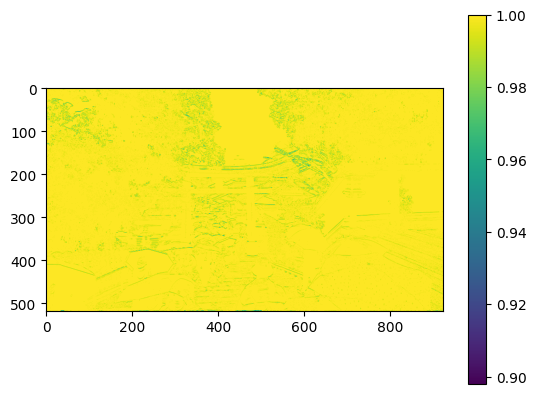

In [13]:
# create an intensity shift to make it easier to change layers on contrast edges
sigma = 3

# img = np.array(img, dtype=float)
h = img - np.roll(img, -1, axis=0)
l = img - np.roll(img, -1, axis=1)
# h = depth - np.roll(depth, -1, axis=0)
# l = depth - np.roll(depth, -1, axis=1)

trans = lambda x : np.exp(-np.sum(x ** 2, axis=2) / (2*(sigma**2)))
# trans = lambda x : np.exp(-x ** 2 / (2*(sigma**2)))

h_m = trans(h)
l_m = trans(l)
plt.imshow(h_m)
plt.colorbar()

In [14]:
g = maxflow.Graph[float]()
# nodeids = g.add_grid_nodes((n, m, 2))
nodeids = g.add_grid_nodes((n, m, 3))

# up t-links cost infinity
g.add_grid_edges(nodeids, weights=np.inf, structure=up, symmetric=False)

# down t-links start from d_max then go to d_min
# g.add_grid_edges(nodeids, weights=loss[:,:,1:-1], structure=down, symmetric=False)
g.add_grid_edges(nodeids, weights=loss[:,:,1:], structure=down, symmetric=False)
g.add_grid_tedges(nodeids[:,:,0], loss[:,:,0], 0) # start is d_max
g.add_grid_tedges(nodeids[:,:,-1], 0, loss[:,:,-1]) # end is d_min

weight = 200

g.add_grid_edges(nodeids, weights=weight*h_m[:,:,None], structure=height_wise, symmetric=True)
g.add_grid_edges(nodeids, weights=weight*l_m[:,:,None], structure=length_wise, symmetric=True)

# perform the graph cut
g.maxflow()
mask = g.get_grid_segments(nodeids)

# sum the amount of nodes below the cut
mask = np.count_nonzero(mask, axis=2)

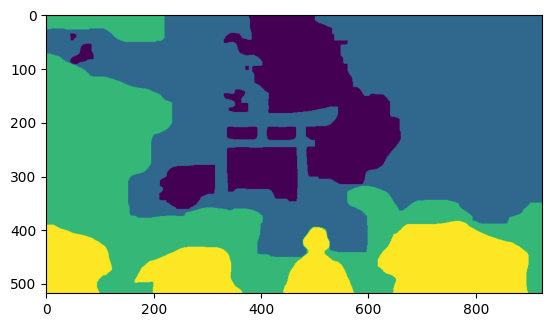

In [15]:
plt.imshow(mask)

In [16]:
from skimage import data, segmentation, graph, color

In [142]:
img = load_image("dataset/torii.jpg")

depth = normalize_image(depth_map(img)) * 100
img = downscale(img, *depth.shape)
cie_img = color.rgb2lab(img)
print(cie_img.shape)

(518, 924, 3)


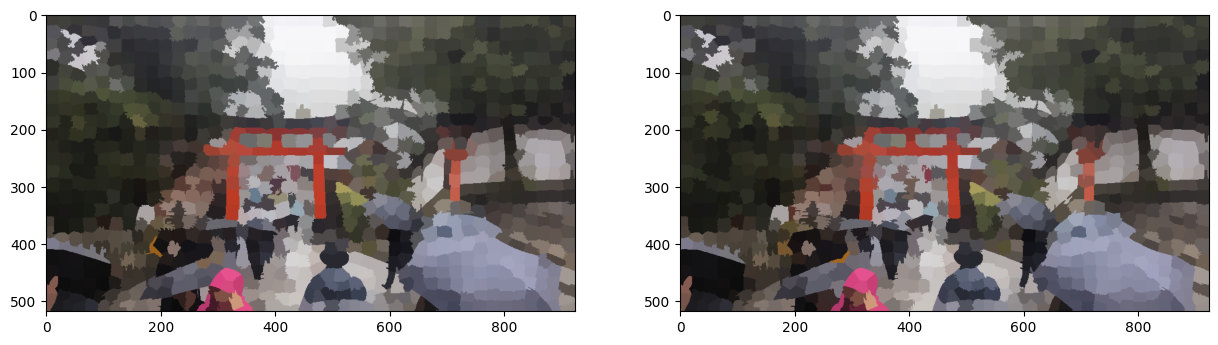

In [77]:
# rgb_slic = slic(img, n_segments=500, compactness=50, start_label=1)
# rgb_slic = slic(img, n_segments=500, start_label=1, slic_zero=True)
rgb_slic = slic(img, n_segments=1000, start_label=1, slic_zero=True)
cie_slic = slic(cie_img, n_segments=1000, start_label=1, slic_zero=True)

# plt.imshow(segmentation.mark_boundaries(img, rgb_slic))
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(color.label2rgb(rgb_slic, img, kind='avg', bg_label=0))
plt.subplot(122)
plt.imshow(color.label2rgb(cie_slic, img, kind='avg', bg_label=0)) # seems to work a little worse (probably cuz not using correct distance metric)

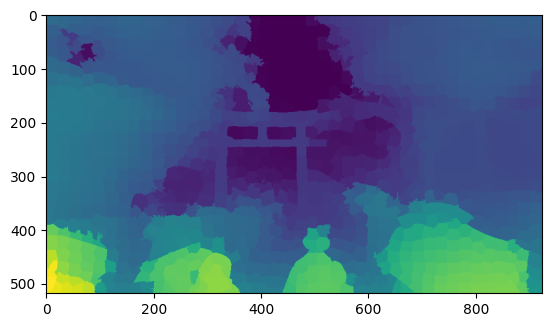

In [78]:
n, m = np.shape(depth)
segment_ids = np.unique(rgb_slic)

masks = np.array([(rgb_slic == i) for i in segment_ids])
d_avgs = np.zeros((n, m), dtype='float')
for mk in masks:
    d_avgs[mk] = np.mean(depth[mk])

plt.imshow(d_avgs)

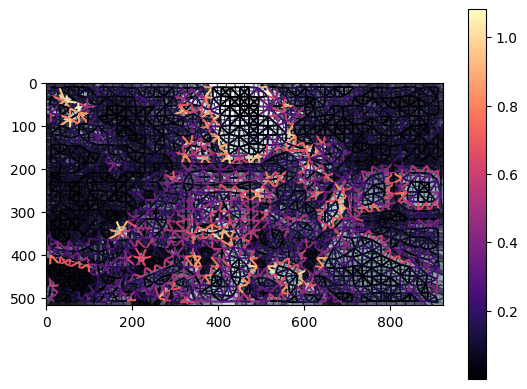

In [79]:
# while this works I need to change the implementation a little bit to get edges and to change the loss function used

g = graph.rag_mean_color(img, rgb_slic)

# g = graph.rag_mean_color(depth, rgb_slic, mode='similarity')
# g = graph.rag_mean_color(depth, rgb_slic)
lc = graph.show_rag(rgb_slic, g, img)
plt.colorbar(lc)

In [80]:
rgb_slic.dtype

dtype('int64')

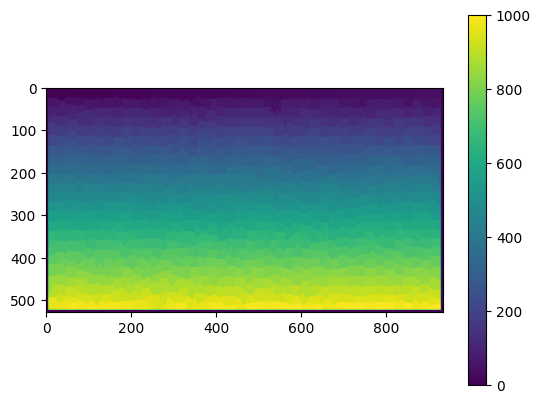

In [144]:
n, m = np.shape(depth)

boundary_slic = np.zeros((n + 10, m + 10), dtype='int64')
boundary_slic[5:-5,5:-5] = rgb_slic

boundary_depth = np.zeros((n + 10, m + 10))
boundary_depth[5:-5,5:-5] = depth

boundary_cie_img = np.zeros((n + 10, m + 10, 3))
boundary_cie_img[5:-5,5:-5,:] = cie_img

boundary_img = np.zeros((n + 10, m + 10, 3))
boundary_img[5:-5,5:-5,:] = img

plt.imshow(boundary_slic)
plt.colorbar()

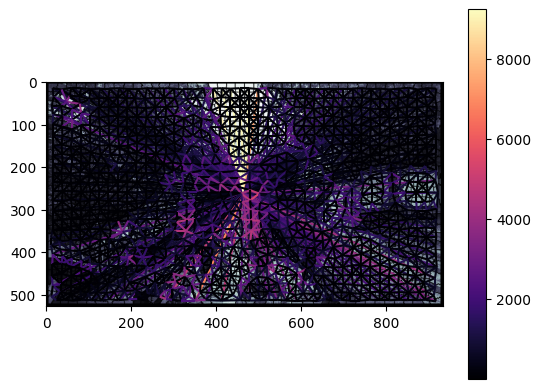

In [234]:
sigma_c = 256
sigma_d = 100

g = graph.RAG(boundary_slic, connectivity=2)

for n in g:
    g.nodes[n].update(
        {
            'labels': [n],
            'mask': None,
            'pixel count': 0,
            'total color': [],
            'total depth': [],
        }
    )

for index in np.ndindex(boundary_slic.shape):
    current = boundary_slic[index]
    g.nodes[current]['pixel count'] += 1
    g.nodes[current]['total color'].append(boundary_cie_img[index])
    g.nodes[current]['total depth'].append(boundary_depth[index])

for n in g:
    g.nodes[n]['mask'] = rgb_slic == n
    g.nodes[n]['total color'] = np.array(g.nodes[n]['total color'], dtype='float64')
    g.nodes[n]['total depth'] = np.array(g.nodes[n]['total depth'], dtype='float64')
    g.nodes[n]['mean color'] = np.sum(g.nodes[n]['total color'] / g.nodes[n]['pixel count'], axis=0)
    g.nodes[n]['mean depth'] = np.sum(g.nodes[n]['total depth'] / g.nodes[n]['pixel count'], axis=0)

for x, y, edge in g.edges(data=True):
    # some kind of loss function with the distance, color difference, and segment anything result
    edge['weight'] = (
        color.deltaE_cie76(g.nodes[x]['mean color'], g.nodes[y]['mean color']) ** 2
        # abs(g.nodes[x]['mean depth'] - g.nodes[y]['mean depth'])
    )
    # we will consider weight when we are actually collecting the superpixels into regions
        # math.e ** (-(diff**2) / sigma)
        # np.exp(-np.sum((g.nodes[x]['mean color'] - g.nodes[y]['mean color']) ** 2) / (2 * (sigma_c ** 2)))  # increase weight for color similarity
        # *
        # np.exp(-np.sum((g.nodes[x]['mean depth'] - g.nodes[y]['mean depth']) ** 2) / (2 * (sigma_d ** 2)))  # increase weight for depth similarity
    
lc = graph.show_rag(boundary_slic, g, boundary_img)
plt.colorbar(lc)

In [235]:
import networkx as nx

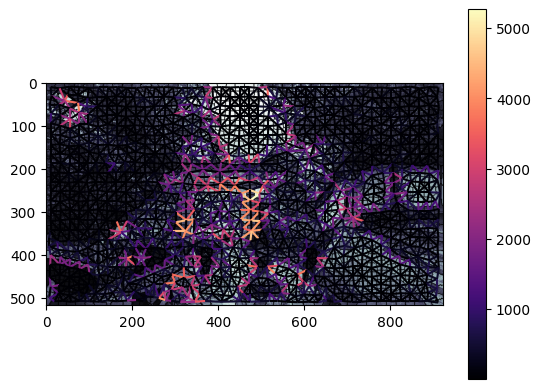

In [237]:
regions = []
for node in nx.all_neighbors(g, 0):
    regions.append(node)
    
for n in regions:
    g.remove_edge(n, 0)

g.remove_node(0)

lc = graph.show_rag(rgb_slic, g, img)
# lc = graph.show_rag(rgb_slic, g, img)
plt.colorbar(lc)

In [238]:
while (g.number_of_nodes() > 4):
    cheapest_edge_val = np.inf
    cheapest_edge = [0, 0]

    for n1 in regions:
        for n2 in nx.all_neighbors(g, n1):
            dst = 5 * (g.nodes[n1]['mean depth'] - g.nodes[n2]['mean depth']) ** 2 + g[n1][n2]['weight'] + (g.nodes[n1]['pixel count'] + g.nodes[n2]['pixel count'])
            if dst < cheapest_edge_val:
                cheapest_edge_val = dst
                cheapest_edge = [n1, n2]

    n1 = cheapest_edge[0]
    n2 = cheapest_edge[1]
    g.remove_edge(n1, n2)
    if n2 in regions:
        regions.remove(n2)

    g.nodes[n1]['mask'] = np.logical_or(g.nodes[n1]['mask'], g.nodes[n2]['mask'])
    g.nodes[n1]['pixel count'] += g.nodes[n2]['pixel count']
    g.nodes[n1]['total color'] = np.append(g.nodes[n1]['total color'], g.nodes[n2]['total color'], axis=0)
    g.nodes[n1]['total depth'] = np.append(g.nodes[n1]['total depth'], g.nodes[n2]['total depth'], axis=0)
    g.nodes[n1]['mean color'] = np.sum(g.nodes[n1]['total color'] / g.nodes[n1]['pixel count'], axis=0)
    g.nodes[n1]['mean depth'] = np.sum(g.nodes[n1]['total depth'] / g.nodes[n1]['pixel count'], axis=0)
    
    n1_con = []
    for c in nx.all_neighbors(g, n1):
        n1_con.append(c)
    for c in n1_con:
        g.remove_edge(n1, c)

    n2_con = []
    for c in nx.all_neighbors(g, n2):
        n2_con.append(c)
    for c in n2_con:
        g.remove_edge(n2, c)

    for n in np.unique(n1_con + n2_con):
        g.add_edge(n1, n)
        g[n1][n]['weight'] = (
            color.deltaE_cie76(g.nodes[n1]['mean color'], g.nodes[n]['mean color'])
            # abs(g.nodes[x]['mean depth'] - g.nodes[y]['mean depth'])
        )

    g.remove_node(n2)

RAG with 4 nodes and 4 edges
[1, 15, 26, 32]


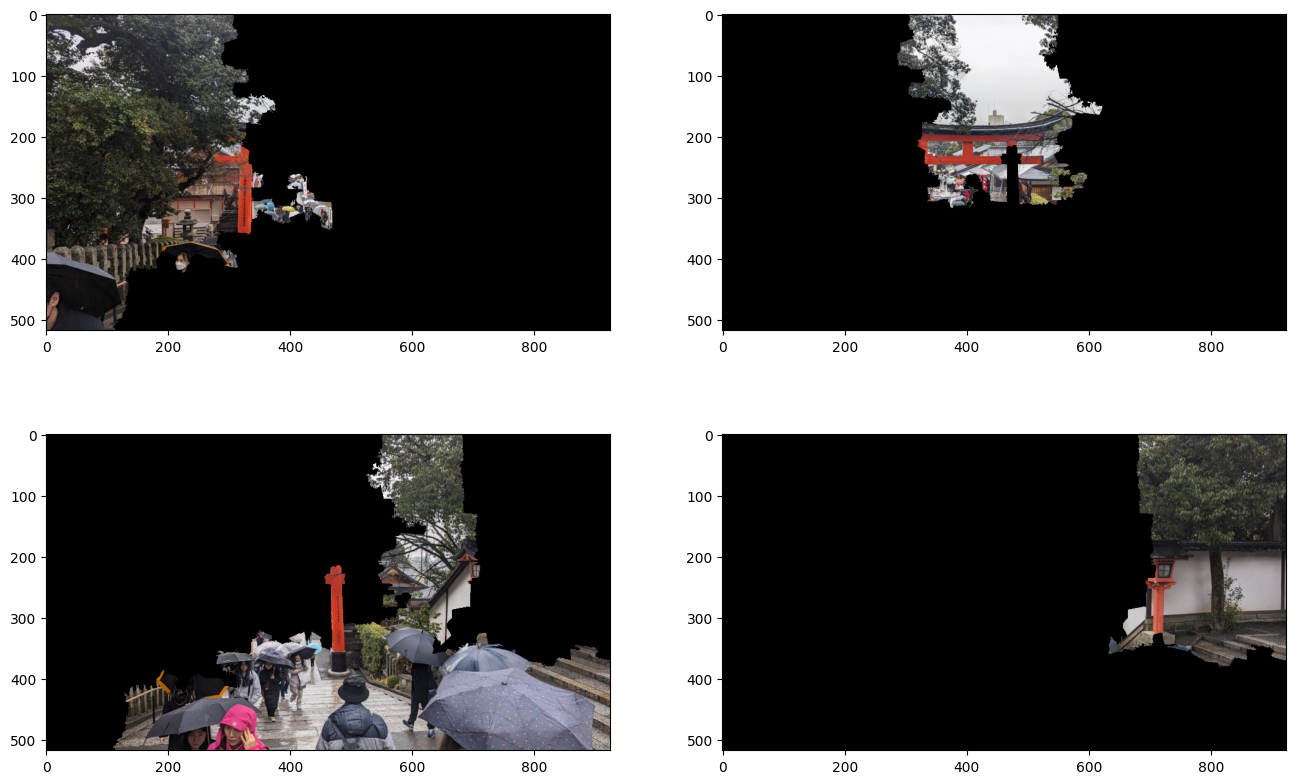

In [239]:
n, m = np.shape(depth)

print(g)
print(regions)

plt.figure(figsize=(16,10))
for i, reg in enumerate(regions):
    plt.subplot(221 + i)
    res = np.zeros((n, m, 3))
    res[g.nodes[reg]['mask']] = img[g.nodes[reg]['mask']]
    plt.imshow(res)
    
# print(g.nodes[1]['mask'].shape)
# print(res.shape)

In [226]:
l = [1, 2, 4]
if 1 in l:
    print('hi')
l.remove(1)
if 3 in l:
    print('hi')
    l.remove(3)
print(l)
for i in np.unique([1, 2, 1, 4]):
    print(i)

hi
[2, 4]
1
2
4


# TODO: keep the most salient objects together
# TODO: should attempt to push the depth amount to ensure that the different layers have significant enough difference in depth
# TODO: create a conda or pip env

what does the edge weight mean?
- at the moment the edge weight is based on the difference in color and depth between superpixels
- this doesn't really make sense because a single object could be made from many colors
    - what if we used the information from the segment anything to get the objects then use superpixels to get a better outline
    - perform segment anything then find all the superpixels that fit inside the segments
    - then for superpixels within a segment make the weights large (and use medium weights for when the color changes but still within same segment)

large weights for parts to slice or small weights for parts to slice
- small weights for the parts to slice
- large weights for parts to keep together
    - or small weights for parts to keep together
    - small difference in depth to keep together
- small dist for depth and color to keep together (choose the smallest disparity value to add)

how do we also consider the depth of the object?
- consider 4 (or as many layers as we want) clouds that are initialized to the kmeans averages for depths over the entire image
- begin by taking the 4 points next to the edge with the nearest depth values
- then we continusouly merge adjacent superpixels based on edge weight (the difference in color and segment anything result) and the difference in average depth for that superpixel
- each time we can update the average depth for our cloud as use that updated depth when looking for the next superpixel

instead of initalizing only 4 clouds we can allow all the edge nodes to be clouds and iterate until there are only 4 left

In [ ]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color. The method expects that the mean color of `dst` is already computed.
    - graph : RAG - The graph under consideration.
    - src, dst : int - The vertices in `graph` to be merged.
    - n : int - A neighbor of `src` or `dst` or both.

    Returns
    - data : dict - A dictionary with the `"weight"` attribute set as the absolute difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph. This method computes the mean color of `dst`.
    - graph : RAG - The graph under consideration.
    - src, dst : int - The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )

labels2 = graph.merge_hierarchical(
    boundary_slic,
    g,
    thresh=4,
    # thresh=0.08,
    rag_copy=False,
    in_place_merge=True,
    merge_func=merge_mean_color,
    weight_func=_weight_mean_color,
)

# out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = color.label2rgb(labels2, img, bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
plt.imshow(out)